# Load in data

In [ ]:
import os
from turtle import title
import mne
import pandas as pd
from pandas import DataFrame, read_csv
import numpy
import re
import numpy as np
from matplotlib import pyplot as plt
from autoreject import get_rejection_threshold
from scipy.stats import ttest_rel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
import seaborn as sns


def format_events_frame(EventsDataFrame):
    # Drop the first column since it's the same as the index
    EventsDataFrame = EventsDataFrame.drop(EventsDataFrame.columns[0], axis=1)

    # Convert 'datetimes' column to datetime format
    EventsDataFrame['datetimes'] = pd.to_datetime(EventsDataFrame['datetimes'], format='%Y-%m-%d %H.%M.%S.%f',
                                                  errors='coerce', utc=True)

    # Gets the seconds that have passed since the trial started
    EventsDataFrame['seconds_since_start'] = (
            EventsDataFrame['datetimes'] - EventsDataFrame['datetimes'].min()).dt.total_seconds()

    # Create 'TID' column based on conditions
    conditions = [
        (EventsDataFrame['events'] == 'START') | (EventsDataFrame['events'] == 'END'),
        (EventsDataFrame['events'] == 'STANDARD'),
        (EventsDataFrame['events'] == 'TARGET')
    ]

    values = [1, 10, 20]

    # Adds the TID next to the events
    EventsDataFrame['TID'] = np.select(conditions, values, default=np.nan)

    # Reorder columns
    EventsDataFrame = EventsDataFrame[
        ['datetimes', 'seconds_since_start', 'events', 'TID'] + [col for col in EventsDataFrame.columns if
                                                                 col not in ['datetimes', 'seconds_since_start',
                                                                             'events', 'TID']]]

    return EventsDataFrame


def format_raw_data_frame(DataFrame, startTime):
    # Convert 'datetime' column to datetime format
    DataFrame['datetime'] = pd.to_datetime(DataFrame['datetime'], format='%Y-%m-%d %H.%M.%S.%f', errors='coerce',
                                           utc=True)

    # Gets the seconds that have passed since the trial started
    DataFrame['seconds_since_start'] = (
            DataFrame['datetime'] - startTime).dt.total_seconds()

    # Get raw channel data
    raw_channel_data = DataFrame[['chnl-1-raw', 'chnl-2-raw', 'chnl-3-raw', 'datetime', 'seconds_since_start']].values.T

    return raw_channel_data


def numeric_participant_sort(dir):
    return int(dir.lstrip("participant"))


def get_trimmed_files():
    base_directory = 'hr_data'

    # The line below searches the hr_data directory for other directories (which contain the test data)
    directories = sorted([f for f in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, f))],
                         key=numeric_participant_sort)

    files = []

    for directory in directories:
        for i in range(1, 9):
            # file_path = f'{base_directory}/{directory}/erp{i}_trim.csv'
            file_path = f'{base_directory}/{directory}/erp{i}_trim.csv'
            files.append(file_path)

    return files


def get_timestamps():
    base_directory = 'hr_data'
    # The line below searches the hr_data directory for other directories (which contain the test data)
    directories = sorted([f for f in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, f))],
                         key=numeric_participant_sort)

    files = []

    for directory in directories:
        subject_base_directory = f'{base_directory}/{directory}'
        # Does the same as before except only grabs the erp directories for a single subject
        erp_directories = [f for f in os.listdir(subject_base_directory)
                           if os.path.isdir(os.path.join(subject_base_directory, f)) and 'erp' in f]

        for erp_directory in erp_directories:
            erp_directory_path = f'{base_directory}/{directory}/{erp_directory}'
            erp_timestamp = [f for f in os.listdir(erp_directory_path) if re.match(r'erp_timestamps_.*\.csv', f)][0]

            files.append(f'{base_directory}/{directory}/{erp_directory}/{erp_timestamp}')

    return files

# last value will be the average
def get_reaction_times():
    import re
    pattern = r"\d+\.\d+"
    milliseconds = []
    with open("hr_data/participant_reaction_times.txt", "r") as file:
        for line in file:
            matches = re.findall(pattern, line)
            if matches:
                milliseconds.extend(matches)

    milliseconds = [float(ms) for ms in milliseconds]
    return milliseconds

def compute_mav_and_var_features(window_data, WSize=20, Hop=5):
    mav_features = []
    var_features = []

    # Calculate MAV and VAR from 300 ms to 520 ms
    for i in range(int(206 * 0.300 + 52), int(206 * 0.520 + 52), Hop):
        window_data = channel_2_data[:, i:i + WSize]

        # Calculate MAV
        mav = np.mean(np.abs(window_data), axis=1)
        mav_features.append(mav)

        # Calculate VAR
        # Newaxis is used to match the shape of the two arrays
        var = 1/WSize * np.sum(np.square(window_data - mav[:, np.newaxis]), axis=1)
        var_features.append(var)

    return np.array(mav_features), np.array(var_features)

TrimmedERPFiles = get_trimmed_files()
ERPTimestamps = get_timestamps()

FileMatrix = [TrimmedERPFiles, ERPTimestamps]

FileDataFrame = pd.DataFrame(FileMatrix)

# Initialize an empty list to store ERP data for each channel
list_of_avg_base_stimuli_across_all_trials = []
list_of_avg_target_stimuli_across_all_trials = []

num_of_targets = 0
num_of_base = 0
drop_count_target = 0
drop_count_base = 0

classifier_data = []

for i in range(FileDataFrame.columns.size):
    ERPDataFrame = read_csv(FileDataFrame[i].iloc[0])
    ERPEventsDataFrame = read_csv(FileDataFrame[i].iloc[1])

    events_info = format_events_frame(ERPEventsDataFrame)

    # start time of the trial
    start_time = events_info['datetimes'].iloc[0]

    # Pass in the ERPDataFrame and the start time of the trial to have an accurate start time for both
    raw_array = format_raw_data_frame(ERPDataFrame, start_time)

    ch_names = ['Channel 1', 'Channel 2', 'Channel 3']

    ch_types = ['eeg', 'eeg', 'eeg']

    sampling_frequency = 206

    info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sampling_frequency)

    raw = mne.io.RawArray(raw_array[:3, :], info).set_meas_date(start_time)

    onset_array = events_info['seconds_since_start'].values

    description_array = events_info['TID'].values.astype(int)

    annotations = mne.Annotations(onset=onset_array, description=description_array, duration=0.001953125,
                                  orig_time=start_time)

    raw.set_annotations(annotations)

    # Begin analysis
    raw.pick_channels(ch_names)

    # Use 5 to 11 to capture Theta + Alpha bands
    # raw.filter(5, 11, fir_design='firwin', fir_window='hamming')
    # raw.filter(5, 7, fir_design='firwin', fir_window='hamming')
    raw.filter(5, 27, fir_design='firwin', fir_window='hamming')

    # raw.compute_psd().plot()

    # Define events based on your experimental paradigm
    events, event_id = mne.events_from_annotations(raw)

    # Where 2 is base and 3 is target stimuli
    if 31 < i < 48 or i == 64:
        event_ids_of_interest = [2, 3]
    else:
        # Where 3 is base and 4 is target stimuli
        event_ids_of_interest = [3, 4]
        # event_ids_of_interest = [2, 3]

    # Picks are just defining what type of channels we are using, in this case EEG and EOG
    picks = mne.pick_types(raw.info, eeg=True)

    # Create epochs around events of interest (e.g., visual stimuli)
    base_epochs = None
    target_epochs = None

    for eid in event_ids_of_interest:
        final_epochs = mne.Epochs(raw, events, eid, tmin=-0.25, tmax=0.75,
                                  preload=True, event_repeated='merge')

        reject = get_rejection_threshold(final_epochs)['eeg']

        final_epochs.drop_bad(reject={'eeg': reject})

        # This line throws out the data for the participant clicking the space bar on all shapes
        if i == 72:
            final_epochs.drop_bad(reject={'eeg': 0})

        # Get drop log
        drop_log = final_epochs.drop_log

        # final_epochs.plot(picks=picks, events=events, scalings=scalings)
        if final_epochs.__len__() != 0:
            final_epochs = final_epochs.apply_baseline(baseline=(-0.25, 0))

            if eid == event_ids_of_interest[0]:
                base_epochs = final_epochs.copy()
                num_of_base += base_epochs.events.shape[0]
                drop_count_base += 80 - final_epochs.__len__()
            else:
                # final_epochs.plot(scalings='auto')
                target_epochs = final_epochs.copy()
                num_of_targets += target_epochs.events.shape[0]
                drop_count_target += 20 - final_epochs.__len__()

    # base_epochs.plot(picks=picks, events=events, scalings='auto')
    # target_epochs.plot(picks=picks, events=events, scalings='auto')

    # The following are evoked objects in mne
    if base_epochs is not None:
        base_epochs_avg = base_epochs.average(picks='eeg')
        list_of_avg_base_stimuli_across_all_trials.append(base_epochs_avg)

        # Calculate mean average value (MAV) with WSize = 20 and Olap = 10 for second channel
        channel_2_data = base_epochs.get_data(picks='eeg')[:, 1, :]

        # Calculate MAV and VAR features
        mav_features, var_features = compute_mav_and_var_features(channel_2_data)

        # Feature dictionary
        for j in range(mav_features.shape[1]):
            feature_dict = {
                'Participant': i,
                'Base/Target': 0
            }
            for k in range(mav_features.shape[0]):
                feature_dict[f'MAV_{k}'] = mav_features[k, j]
                feature_dict[f'VAR_{k}'] = var_features[k, j]
            classifier_data.append(feature_dict)

    if target_epochs is not None:
        target_epochs_avg = target_epochs.average(picks='eeg')
        list_of_avg_target_stimuli_across_all_trials.append(target_epochs_avg)

        # Calculate mean average value (MAV) with WSize = 20 and Olap = 10 for second channel
        channel_2_data = target_epochs.get_data(picks='eeg')[:, 1, :]

        # Calculate MAV and VAR features
        mav_features, var_features = compute_mav_and_var_features(channel_2_data)

        # Feature dictionary
        for j in range(mav_features.shape[1]):
            feature_dict = {
                'Participant': i,
                'Base/Target': 1
            }
            for k in range(mav_features.shape[0]):
                feature_dict[f'MAV_{k}'] = mav_features[k, j]
                feature_dict[f'VAR_{k}'] = var_features[k, j]
            classifier_data.append(feature_dict)

classifier_df = pd.DataFrame(classifier_data)

# base_epochs_avg.plot(picks='eeg')
# target_epochs_avg.plot(picks='eeg')
# Take the grand average of the base and target stimulis
grand_average_base_stimuli = mne.grand_average(list_of_avg_base_stimuli_across_all_trials)
grand_average_target_stimuli = mne.grand_average(list_of_avg_target_stimuli_across_all_trials)

# Calculate the number of rows and columns for the grid
num_rows = 3
num_cols = 1

# Calculate the number of subplots needed
num_subplots = int(np.ceil(len(ch_names) / (num_rows * num_cols)))

# Determine y-axis limits across all channels
min_y = float('inf')
max_y = float('-inf')

for ch_name in ch_names:
    base_data = grand_average_base_stimuli.get_data(picks=ch_name)
    target_data = grand_average_target_stimuli.get_data(picks=ch_name)

    min_y = min(min_y, np.min([base_data, target_data]))
    max_y = max(max_y, np.max([base_data, target_data]))


# Get reaction times and standard deviation
reaction_times = get_reaction_times()
std_dev = np.std(reaction_times[:-1])

# Plots


## Reaction Time

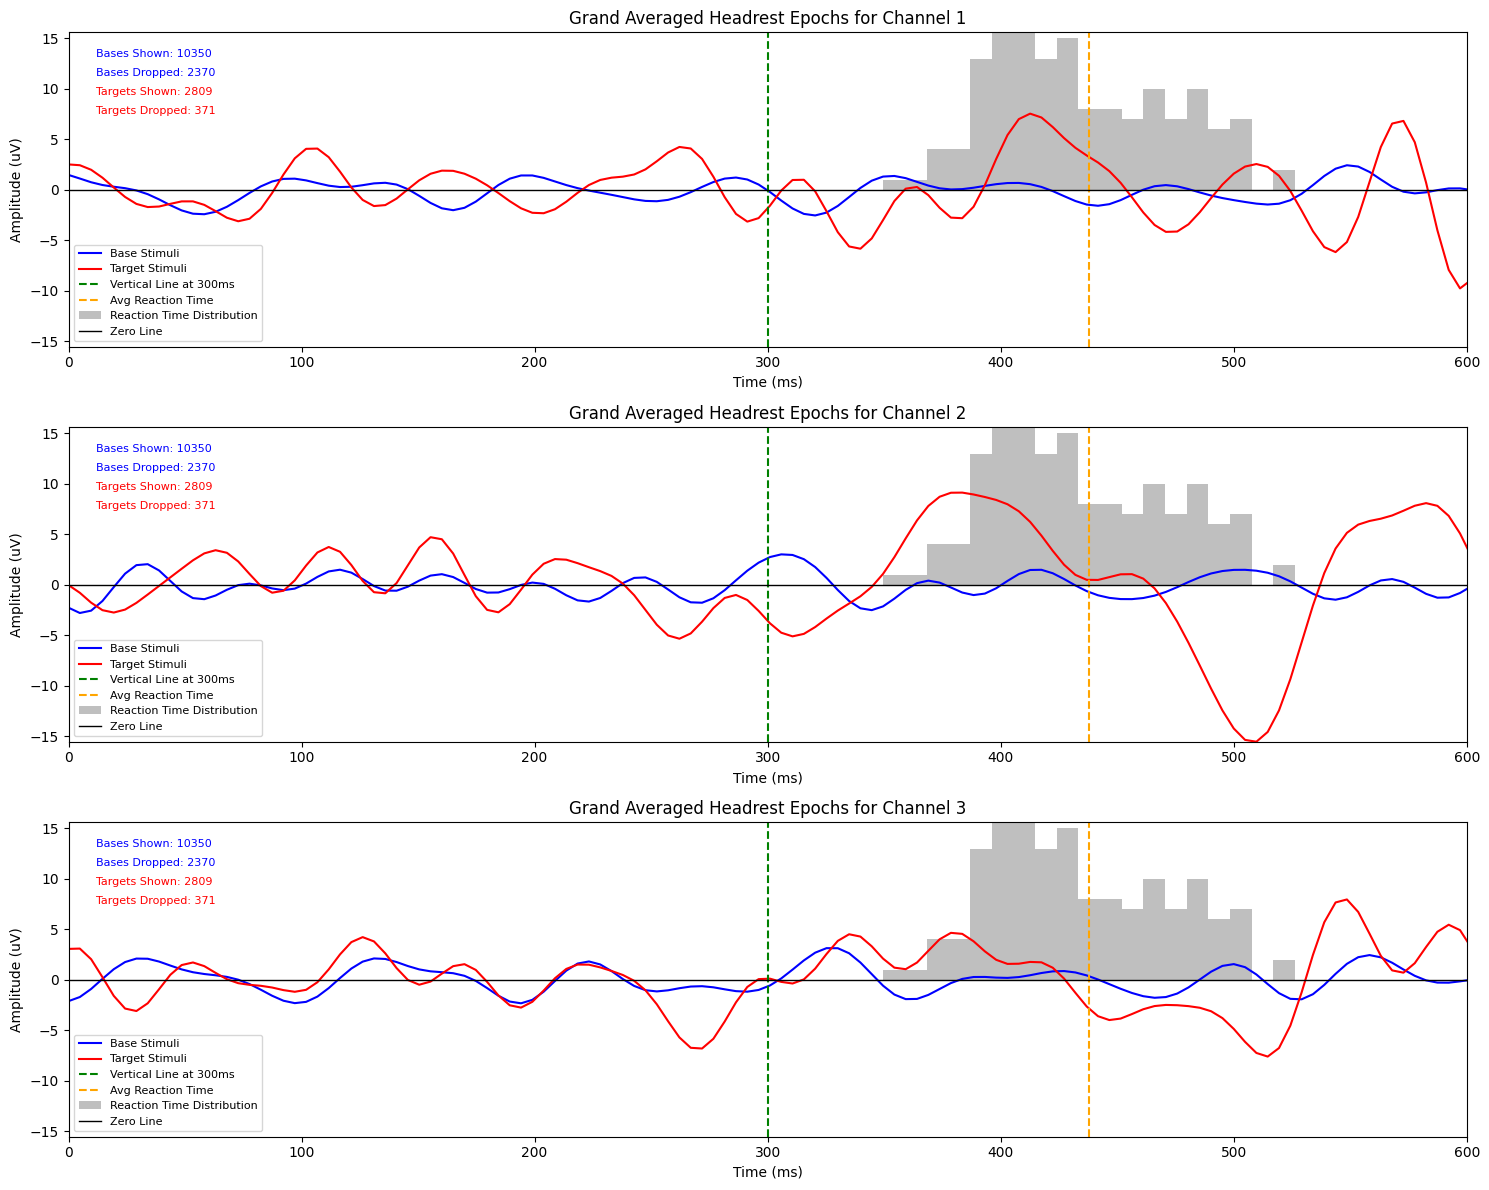

In [93]:
# Loop over subplots
for subplot_idx in range(num_subplots):
    start_channel_idx = subplot_idx * num_rows * num_cols
    end_channel_idx = (subplot_idx + 1) * num_rows * num_cols

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 12))

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    # Loop over channels and plot on separate subplots
    for idx, ch_name in enumerate(ch_names[start_channel_idx:end_channel_idx]):
        base_data = grand_average_base_stimuli.get_data(picks=ch_name)
        target_data = grand_average_target_stimuli.get_data(picks=ch_name)

        # Plot the data for the current channel on the corresponding subplot
        axes[idx].plot(grand_average_base_stimuli.times * 1000, base_data[0], label='Base Stimuli', color='blue')
        axes[idx].plot(grand_average_target_stimuli.times * 1000, target_data[0], label='Target Stimuli', color='red')

        # Add vertical lines at specific time points
        axes[idx].axvline(x=300, color='green', linestyle='--', label='Vertical Line at 300ms')
        axes[idx].axvline(x=reaction_times[-1], color='orange', linestyle='--', label='Avg Reaction Time')

        # Plot histogram of reaction times around the average reaction time
        bins = np.linspace(reaction_times[-1] - 2 * std_dev, reaction_times[-1] + 2 * std_dev, 20)
        axes[idx].hist(reaction_times, bins=bins, alpha=0.5, color='gray', label='Reaction Time Distribution')

        # Add a horizontal line at y=0
        axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=1, label='Zero Line')

        # Set labels and title
        axes[idx].set_title(f'Grand Averaged Headrest Epochs for {ch_name}')
        axes[idx].set_xlabel('Time (ms)')
        axes[idx].set_ylabel('Amplitude (uV)')

        # Invert the y-axis to flip the negative values upwards
        # axes[idx].invert_yaxis()

        # Set y-axis limits
        axes[idx].set_ylim(min_y, max_y)

        # Set x-axis limits to 0 to 600 milliseconds
        axes[idx].set_xlim(0, 600)

        # Add legend
        axes[idx].legend(loc='lower left', fontsize=8)

        # Add annotations for Targets Shown and Bases Dropped
        targets_shown = f"Targets Shown: {num_of_targets}"
        targets_dropped = f"Targets Dropped: {drop_count_target}"
        bases_shown = f"Bases Shown: {num_of_base}"
        bases_dropped = f"Bases Dropped: {drop_count_base}"
        axes[idx].annotate(bases_shown, xy=(0.02, 0.92), xycoords='axes fraction', fontsize=8, color='blue')
        axes[idx].annotate(bases_dropped, xy=(0.02, 0.86), xycoords='axes fraction', fontsize=8, color='blue')
        axes[idx].annotate(targets_shown, xy=(0.02, 0.80), xycoords='axes fraction', fontsize=8, color='red')
        axes[idx].annotate(targets_dropped, xy=(0.02, 0.74), xycoords='axes fraction', fontsize=8, color='red')

    # Adjust layout with auto spacing
    plt.tight_layout()


## P-value


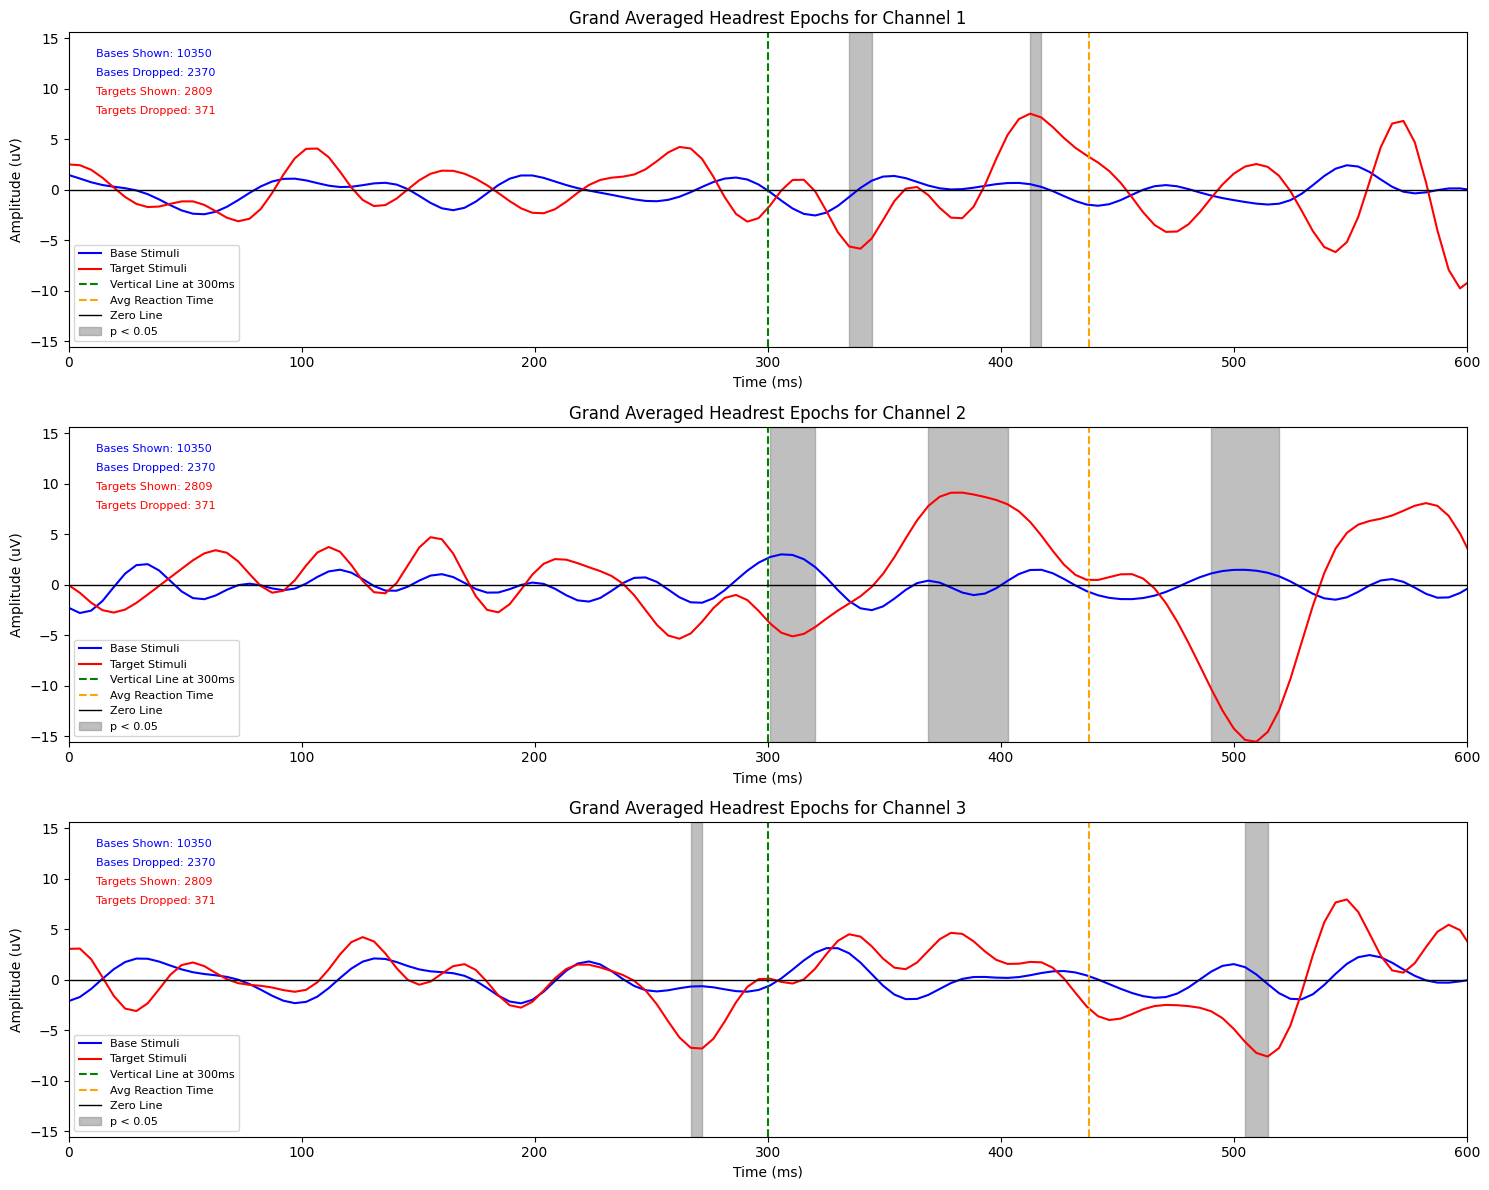

In [94]:
# Graph with p-values 

# Convert data to numpy arrays
data_base = np.array([evoked.data for evoked in list_of_avg_base_stimuli_across_all_trials])
data_target = np.array([evoked.data for evoked in list_of_avg_target_stimuli_across_all_trials])

# Perform paired t-test
p_values = []
for i in range(data_base.shape[2]):
    _, p = ttest_rel(data_base[:, :, i], data_target[:, :, i], axis=0)
    p_values.append(p)

p_values = np.array(p_values).T

# Loop over subplots and show shading of p-values below 0.05
for subplot_idx in range(num_subplots):
    start_channel_idx = subplot_idx * num_rows * num_cols
    end_channel_idx = (subplot_idx + 1) * num_rows * num_cols
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 12))

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    # Loop over channels and plot on separate subplots
    for idx, ch_name in enumerate(ch_names[start_channel_idx:end_channel_idx]):
        base_data = grand_average_base_stimuli.get_data(picks=ch_name)
        target_data = grand_average_target_stimuli.get_data(picks=ch_name)

        # Plot the data for the current channel on the corresponding subplot
        axes[idx].plot(grand_average_base_stimuli.times * 1000, base_data[0], label='Base Stimuli', color='blue')
        axes[idx].plot(grand_average_target_stimuli.times * 1000, target_data[0], label='Target Stimuli', color='red')

        # Add vertical lines at specific time points
        axes[idx].axvline(x=300, color='green', linestyle='--', label='Vertical Line at 300ms')
        axes[idx].axvline(x=reaction_times[-1], color='orange', linestyle='--', label='Avg Reaction Time')
        axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=1, label='Zero Line')
        axes[idx].set_title(f'Grand Averaged Headrest Epochs for {ch_name}')
        axes[idx].set_xlabel('Time (ms)')
        axes[idx].set_ylabel('Amplitude (uV)')
        axes[idx].set_ylim(min_y, max_y)

        # Set x-axis limits to 0 to 600 milliseconds
        axes[idx].set_xlim(0, 600)

        # Shade the area where p-values are below 0.05
        axes[idx].fill_between(grand_average_base_stimuli.times * 1000, min_y, max_y,
                            where=p_values[idx] < 0.05, color='gray', alpha=0.5, label='p < 0.05')
        
        axes[idx].legend(loc='lower left', fontsize=8)
        targets_shown = f"Targets Shown: {num_of_targets}"
        targets_dropped = f"Targets Dropped: {drop_count_target}"
        bases_shown = f"Bases Shown: {num_of_base}"
        bases_dropped = f"Bases Dropped: {drop_count_base}"
        axes[idx].annotate(bases_shown, xy=(0.02, 0.92), xycoords='axes fraction', fontsize=8, color='blue')
        axes[idx].annotate(bases_dropped, xy=(0.02, 0.86), xycoords='axes fraction', fontsize=8, color='blue')
        axes[idx].annotate(targets_shown, xy=(0.02, 0.80), xycoords='axes fraction', fontsize=8, color='red')
        axes[idx].annotate(targets_dropped, xy=(0.02, 0.74), xycoords='axes fraction', fontsize=8, color='red')
    plt.tight_layout()

# Modeling

In [ ]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = classifier_df.drop(columns=['Participant', 'Base/Target'])
y = classifier_df['Base/Target']
groups = classifier_df['Participant']

# Split data into training and testing sets
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.2, stratify=groups, random_state=42)

# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame
X_train = pd.DataFrame(X_train, columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(X_test, columns=X.columns, index=X_test.index)

# Initialize lists to store the accuracy and confusion matrix for LOPO CV
accuracy = []
aucs = []
f1_scores = []
confusion_matrices = []

cv = LeaveOneGroupOut()
clf = LinearDiscriminantAnalysis()
clf = LogisticRegression(max_iter=1000)

for train_index, val_index in cv.split(X_train, y_train, groups_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Combine X_train_fold and y_train_fold for balancing
    train_data = pd.concat([X_train_fold, y_train_fold], axis=1)
    base_train = train_data[train_data['Base/Target'] == 0]
    target_train = train_data[train_data['Base/Target'] == 1]
    
    # Randomly sample base_train to match the number of target_train
    sampled_base_train = base_train.sample(n=target_train.shape[0], random_state=42)
    balanced_train = pd.concat([sampled_base_train, target_train])
    
    X_train_balanced = balanced_train.drop(columns=['Base/Target'])
    y_train_balanced = balanced_train['Base/Target']
    
    clf.fit(X_train_balanced, y_train_balanced)
    accuracy.append(clf.score(X_val_fold, y_val_fold))
    
    # Calculate metrics
    y_pred = clf.predict(X_val_fold)
    y_prob = clf.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_prob)
    aucs.append(auc)
    f1_scores.append(f1_score(y_val_fold, y_pred, average='macro'))
    cm = confusion_matrix(y_val_fold, y_pred)
    confusion_matrices.append(cm)

### LOPO CV Metrics

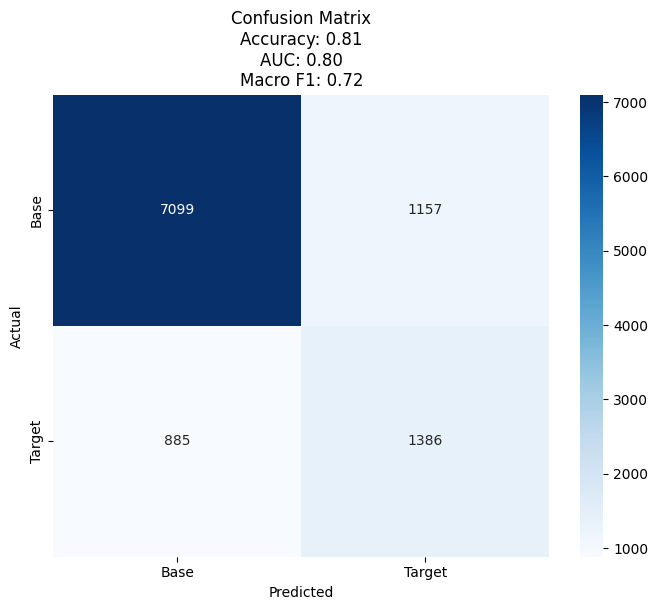

In [104]:
mean_accuracy = np.mean(accuracy)
mean_auc = np.mean(aucs)

# Calculate the mean confusion matrix
mean_cm = np.sum(confusion_matrices, axis=0) 
macro_f1 = np.mean(f1_scores)

plt.figure(figsize=(8, 6))
sns.heatmap(mean_cm, annot=True, cmap='Blues', xticklabels=['Base', 'Target'], yticklabels=['Base', 'Target'], fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {mean_accuracy:.2f}\nAUC: {mean_auc:.2f}\nMacro F1: {macro_f1:.2f}')
plt.show()

### Test Set Metrics

In [ ]:
# Test on test set
clf_final = LinearDiscriminantAnalysis()
clf_final = LogisticRegression(max_iter=1000)

# Balance the training set
train_data = pd.concat([X_train, y_train], axis=1)
base_train = train_data[train_data['Base/Target'] == 0]
target_train = train_data[train_data['Base/Target'] == 1]
sampled_base_train = base_train.sample(n=target_train.shape[0], random_state=42)
balanced_train = pd.concat([sampled_base_train, target_train])
X_train_balanced = balanced_train.drop(columns=['Base/Target'])
y_train_balanced = balanced_train['Base/Target']

clf_final.fit(X_train_balanced, y_train_balanced)

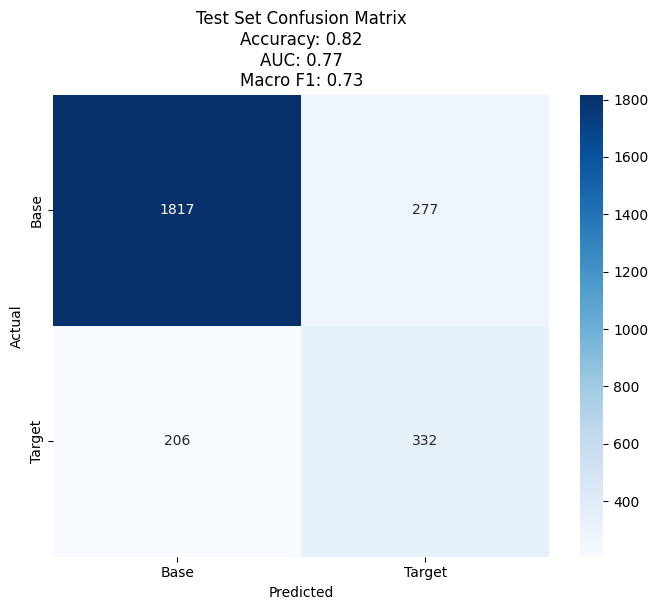

In [106]:
test_accuracy = clf_final.score(X_test, y_test)
y_test_pred = clf_final.predict(X_test)
y_test_prob = clf_final.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_prob)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
test_cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Blues', xticklabels=['Base', 'Target'], yticklabels=['Base', 'Target'], fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Test Set Confusion Matrix\nAccuracy: {test_accuracy:.2f}\nAUC: {test_auc:.2f}\nMacro F1: {test_f1:.2f}')
plt.show()